In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.optim.optimizer import Optimizer

## Dataset

### Jeux de Données linéaire

In [2]:
# Génération du jeu de donn ́ees lin ́eaire
np.random.seed(0)
n_samples = 100
x_linear = np.linspace(-10, 10, n_samples)
y_linear = 3 * x_linear + 5 + np.random.normal(0, 2,
n_samples)

### Jeux de Données non-linéaire

In [3]:
# Génération du jeu de données non linéaire
y_nonlinear = 0.5 * x_linear**2 - 4 * x_linear + np.random. normal(0, 5, n_samples)

### Data graphics

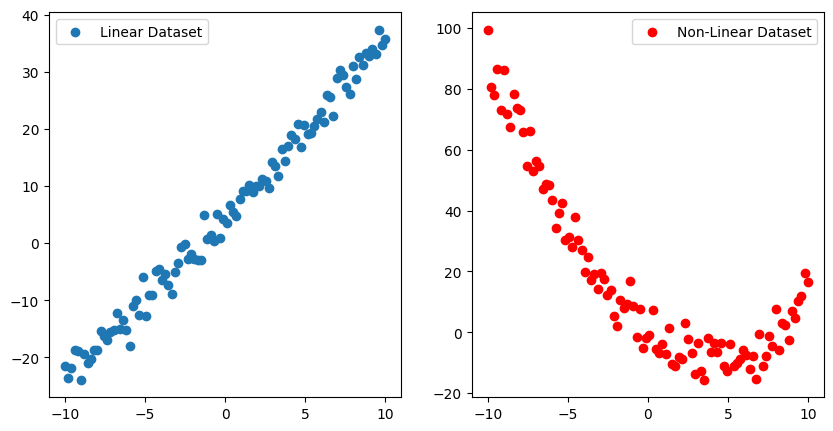

In [4]:
# Plot datasets
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_linear, y_linear, label='Linear Dataset')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x_linear, y_nonlinear, label='Non-Linear Dataset', color='red')
plt.legend()
plt.show()

## Présentation des Algorithmes

### Stochastic Gradient Descent (SGD)

SGD est une méthode d’optimisation qui met à jour les paramètres du modèle en fonction du gradient de la fonction de perte par rapport aux paramètres.

Pour implémenter l'optimizer selon la formule donnée par l'énoncé, il faudra d'abord parcourir les paramètres passés en input et skip si aucun gradient n'est disponible puis ensuite appliquer la formule en multipliant la data par le learning_rate en le soustraire par l'ancien gradient précédent.

In [5]:
class SGD(Optimizer):
    def __init__(self, params, learning_rate=0.01):
        if learning_rate <= 0.0 :
            raise ValueError("Learning rate must be positive")
        
        defaults = {'learning_rate': learning_rate}
        super(SGD, self).__init__(params, defaults)
    
    def step(self, closure=None):
        # Iterate through parameter groups
        for group in self.param_groups:
            learning_rate = group['learning_rate']
            
            # Iterate through parameters in the group
            for param in group['params']:
                # Skip if no gradient is available
                if param.grad is None:
                    continue  

                # Update the parameter using the gradient
                param.data -= learning_rate * param.grad.data

### RMSProp

RMSProp adapte le taux d’apprentissage pour chaque paramètre en fonction de la moyenne des carrés des gradients passés

Nous allons donc set les variables learning_rate et decay.
Une variable d'état square_avg est créée si elle n'existe pas déjà pour stocker la moyenne des carrés des gradients. Cela permet de suivre l'historique des gradients pour chaque paramètre.

Celui-ci est update avec le facteur décroissance decay qui contrôle l'importance des gradients passés.

La racine carrée de square_avg est utilisée pour normaliser l'amplitude des gradients.
Epsilon rajouté car se trouvant dans la formule pour la stabilité de celle-ci

In [6]:
class RMSProp(Optimizer):
    def __init__(self, params, learning_rate=0.01, decay=0.9, epsilon=1e-8):
        if learning_rate <= 0.0:
            raise ValueError("Learning rate must be positive")
        if not 0.0 <= decay < 1.0:
            raise ValueError("Decay must be positive and less than 1")
        
        defaults = {
            'learning_rate': learning_rate,
            'decay': decay,
            'epsilon': epsilon
        }
        super(RMSProp, self).__init__(params, defaults)

    def step(self, closure=None):
        for group in self.param_groups:
            learning_rate = group['learning_rate']
            decay = group['decay']
            epsilon = group['epsilon']
            
            for param in group['params']:
                if param.grad is None:
                    continue
                
                grad = param.grad.data
                
                # Initialize state for square_avg
                state = self.state[param]
                if 'square_avg' not in state:
                    state['square_avg'] = torch.zeros_like(param.data)
                
                square_avg = state['square_avg']
                
                # Update moving average of squared gradients
                square_avg.mul_(decay).addcmul_(grad, grad, value=1 - decay)
                
                # Update parameters
                param.data -= learning_rate * grad / (square_avg.sqrt() + epsilon)


## Adagrad

Adagrad ajuste le taux d’apprentissage pour chaque paramètre en fonction des gradients pass ́es, favorisant des mises à jour plus importantes pour les paramètres moins fréquemment mis à jour.

L'état de chaque paramètre conserve une variable sum_of_squares, représentant la somme cumulative des carrés des gradients Gt​.
Les mises à jour sont normalisées en divisant par la racine carré de Gt​+ϵ ​, ce qui réduit l'importance des mises à jour pour des dimensions avec de grands gradients cumulatifs

In [7]:
class Adagrad(Optimizer):
    def __init__(self, params, learning_rate=0.01, epsilon=1e-10):
        if learning_rate <= 0.0:
            raise ValueError("Learning rate must be positive")
        
        if epsilon <= 0.0:
            raise ValueError("Epsilon must be positive")
        
        defaults = {
            'learning_rate': learning_rate,
            'epsilon': epsilon
        }
        super(Adagrad, self).__init__(params, defaults)
    
    def step(self, closure=None):
        for group in self.param_groups:
            learning_rate = group['learning_rate']
            epsilon = group['epsilon']
            
            for param in group['params']:
                if param.grad is None:
                    continue
                
                grad = param.grad.data
                
                # Initialiser le Gt pour chaque paramètre
                if 'sum_of_squares' not in self.state[param]:
                    self.state[param]['sum_of_squares'] = torch.zeros_like(grad)
                
                sum_of_squares = self.state[param]['sum_of_squares']
                
                # Update la somme des carrés des gradients
                sum_of_squares.addcmul_(grad, grad, value=1)
                
                # Update les paramètres en utilisant la formule
                param.data -= learning_rate * grad / (sum_of_squares.sqrt() + epsilon)

## Adam

Adam combine les avantages de RMSProp et de Momentum en utilisant des moments exponentiels pour estimer les premiers et seconds moments des gradients.

Les paramètres :
- learning_rate (η) : Taux d'apprentissage.
- beta1 (β1) : Facteur de pondération pour le premier moment (mtmt​).
- beta2 (β2) : Facteur de pondération pour le second moment (vtvt​).
- epsilon (ϵ) : Petit terme ajouté pour éviter les divisions par zéro.

Tout d'abord, on initialise les moments avec les variables m, v, ensuite avec la formule donnée dans l'énoncé on calcule 
les moments exponentiels en combinant les valeurs précédentes (mt−1​, vt−1​) avec les gradients actuels (∇θL(θt)).
Après ça pour éviter les biais initiaux (lorsque m0=0 et v0=0), les moments sont corrigés.
Pour finir, on update les paramètres 

In [8]:
class Adam(Optimizer):
    def __init__(self, params, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        defaults = {
            'learning_rate': learning_rate,
            'beta1': beta1,
            'beta2': beta2,
            'epsilon': epsilon
        }
        super(Adam, self).__init__(params, defaults)

    def step(self, closure=None):
        for group in self.param_groups:
            learning_rate = group['learning_rate']
            beta1 = group['beta1']
            beta2 = group['beta2']
            epsilon = group['epsilon']

            for param in group['params']:
                if param.grad is None:
                    continue
                
                grad = param.grad.data
                if param not in self.state:
                    self.state[param] = {
                        'step': 0,
                        'm': torch.zeros_like(param.data),  # Premier moment
                        'v': torch.zeros_like(param.data)   # Second moment
                    }

                state = self.state[param]
                m, v = state['m'], state['v']

                # Incrémenter le compteur de pas
                state['step'] += 1
                step = state['step']

                # Update des moments exponentiels
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Calcululate des moments corrigés par le biais
                m_hat = m / (1 - beta1 ** step)
                v_hat = v / (1 - beta2 ** step)

                # Update des paramètres
                param.data.addcdiv_(-learning_rate * m_hat, (v_hat.sqrt() + epsilon))


## AdamW

AdamW est une variante d’Adam qui ajoute une régularisation L2 pour améliorer la généralisation.

Même chose que Adam optimizer sauf que l'on ajoute la régularization qui est le weight decay.

In [9]:
class AdamW(Optimizer):
    def __init__(self, params, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.01):
        defaults = {
            'learning_rate': learning_rate,
            'beta1': beta1,
            'beta2': beta2,
            'epsilon': epsilon,
            'weight_decay': weight_decay
        }
        super(AdamW, self).__init__(params, defaults)

    def step(self, closure=None):
        for group in self.param_groups:
            learning_rate = group['learning_rate']
            beta1 = group['beta1']
            beta2 = group['beta2']
            epsilon = group['epsilon']
            weight_decay = group['weight_decay']

            for param in group['params']:
                if param.grad is None:
                    continue
                
                grad = param.grad.data

                if param not in self.state:
                    self.state[param] = {
                        'step': 0,
                        'm': torch.zeros_like(param.data),  # Premier moment
                        'v': torch.zeros_like(param.data)   # Second moment
                    }

                state = self.state[param]
                m, v = state['m'], state['v']

                state['step'] += 1
                step = state['step']

                # Update biased first and second moment estimates
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                 # Calcululate des moments corrigés par le biais
                m_hat = m / (1 - beta1 ** step)
                v_hat = v / (1 - beta2 ** step)

                # Update des paramètres avec weight decay (L2 regularization)
                param.data.add_(-learning_rate * weight_decay, param.data)  #  weight decay
                param.data.addcdiv_(-learning_rate * m_hat, (v_hat.sqrt() + epsilon))  #  Adam update

# Evaluation des optimiseurs

In [10]:
def f(x):
    return (x - 2)**2
def f_nonconvexe(x): 
    return 3*x**2 - 2*x

In [11]:
# Evaluation function for optimizers
def eval_optim():
    # Definit x comme le paramètres initial comme a learnable tensor)
    x = torch.tensor([0.0], requires_grad=True)  

    # List of optimizers to evaluate
    optimizers = {
        "SGD": SGD([x], learning_rate=0.1),
        "RMSProp": RMSProp([x], learning_rate=0.1),
        "Adagrad": Adagrad([x], learning_rate=0.1),
        "Adam": Adam([x], learning_rate=0.1),
        "AdamW": AdamW([x], learning_rate=0.1, weight_decay=0.01)
    }

    # Loss functions to evaluate
    loss_functions = {
        "Convex": f,
        "Non-Convex": f_nonconvexe
    }

    result = {}
    step = 20
    for loss_name, loss_fn in loss_functions.items():
        print(f"\nEvaluating on {loss_name} Loss Function (x, loss):")
        
        for optim_name, optimizer in optimizers.items():
            # Reset parameter x to 0 for each optimizer
            x.data = torch.tensor([0.0])

            # print(f"\nOptimizer: {optim_name}")
            for step in range(step):  
                # On reset le gradient
                optimizer.zero_grad() 
                
                # Compute la loss 
                loss = loss_fn(x)
                
                # Compute gradients
                loss.backward()
                
                # Update x
                optimizer.step()

                # Print progress
                # print(f"Step {step + 1:02d}: x = {x.item():.4f}, Loss = {loss.item():.4f}")
            result[optim_name] = (x.item(), loss.item())
        print(result)
            
eval_optim()


Evaluating on Convex Loss Function (x, loss):
{'SGD': (1.976941466331482, 0.000830773264169693), 'RMSProp': (1.8312522172927856, 0.03999539464712143), 'Adagrad': (0.6596569418907166, 1.8502353429794312), 'Adam': (1.5680800676345825, 0.2586780786514282), 'AdamW': (1.4806982278823853, 0.3574395477771759)}

Evaluating on Non-Convex Loss Function (x, loss):
{'SGD': (0.33333298563957214, -0.3333333134651184), 'RMSProp': (0.33333295583724976, -0.3333333134651184), 'Adagrad': (0.14167165756225586, -0.21363523602485657), 'Adam': (0.590474545955658, -0.14301443099975586), 'AdamW': (0.5916758179664612, -0.1528463363647461)}


/var/folders/_t/_09rqyyj0v3g_c9sgq8sp4k40000gn/T/ipykernel_2869/855372235.py:48: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1630.)
  param.data.add_(-learning_rate * weight_decay, param.data)  #  weight decay


# Réseaux de Neurones

In [12]:
def func_nn(x, W1, b1, W2, b2): 
    h1 = W1 * x + b1
    y = W2 * h1 + b2 
    return y

def mse(y, y_hat):
    return (y - y_hat) ** 2

La fonction eval_nn_optim est conçue pour évaluer et comparer les performances de différents algorithmes d’optimisation dans un contexte d’apprentissage supervisé. Elle commence par générer des données simples représentant une relation linéaire y=3x+2, avec des entrées uniformément réparties. Ces données servent à entraîner un réseau de neurones à une seule couche cachée, dont les paramètres (W1,W2,b1,b2) sont initialisés aléatoirement avec des gradients activés.

Les optimiseurs testés incluent des méthodes classiques comme SGD, RMSProp, Adagrad, Adam et AdamW, chacune configurée avec un taux d’apprentissage spécifique. Pour chaque optimiseur, la fonction réinitialise les paramètres du modèle avant de procéder à un entraînement de 100 itérations. À chaque étape, la fonction calcule les prédictions du réseau, évalue la perte à l’aide de la fonction d’erreur quadratique moyenne MSE, et met à jour les paramètres via l’optimiseur choisi.

À la fin de l’entraînement, la perte finale pour chaque optimiseur est enregistrée dans un dictionnaire et affichée. Cela permet d’identifier l’optimiseur qui converge le mieux pour minimiser la perte. Cette fonction est utile pour comprendre les différences entre les algorithmes d’optimisation et leur efficacité dans un cadre simple, bien que les résultats puissent varier selon les hyperparamètres ou la complexité du modèle.

In [13]:
# Entraînement du réseau
def eval_nn_optim():
    # Génération de données simples
    x = torch.linspace(-1, 1, 100)  # Entrées
    y_true = 3 * x + 2  # Sorties cibles (relation linéaire)

    # Initialisation des paramètres du réseau
    W1 = torch.randn(1, requires_grad=True)
    b1 = torch.randn(1, requires_grad=True)
    W2 = torch.randn(1, requires_grad=True)
    b2 = torch.randn(1, requires_grad=True)

    # Liste des optimiseurs à tester
    optimizers = {
        "SGD": SGD([W1, b1, W2, b2], learning_rate=0.1),
        "RMSProp": RMSProp([W1, b1, W2, b2], learning_rate=0.1),
        "Adagrad": Adagrad([W1, b1, W2, b2], learning_rate=0.1),
        "Adam": Adam([W1, b1, W2, b2], learning_rate=0.1),
        "AdamW": AdamW([W1, b1, W2, b2], learning_rate=0.1, weight_decay=0.01)
    }

    step = 100
    result = {}
    
    # Boucle d'évaluation
    for optim_name, optimizer in optimizers.items():
        # print(f"\nOptimiseur : {optim_name}")

        # Réinitialisation des paramètres
        W1.data = torch.randn(1)
        b1.data = torch.randn(1)
        W2.data = torch.randn(1)
        b2.data = torch.randn(1)

        # Training of steps
        for epoch in range(step):
            optimizer.zero_grad()  # Reinitialize the gradients

            # Calculate the prediction
            y_pred = func_nn(x, W1, b1, W2, b2)

            # loss calculation
            loss = mse(y_true, y_pred).mean()
            loss.backward()  # Gradient calculation
            optimizer.step()  # Update the parameters

            # Display the epoch
            # if (epoch + 1) % 10 == 0:
            #     print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}")
                
        result[optim_name] = loss.item()
    print(result)
    return result
eval_nn_optim()

{'SGD': 7.258194154209641e-14, 'RMSProp': 0.028666885569691658, 'Adagrad': 0.09497125446796417, 'Adam': 5.608999344985932e-05, 'AdamW': 0.00011092250497313216}


{'SGD': 7.258194154209641e-14,
 'RMSProp': 0.028666885569691658,
 'Adagrad': 0.09497125446796417,
 'Adam': 5.608999344985932e-05,
 'AdamW': 0.00011092250497313216}

# Scheduler de Taux d'apprentissage

## LRScheduler

La classe LRScheduler permet de gérer cette réduction progressive du taux d'apprentissage en multipliant ce dernier par 0.95 à chaque étape de l'entraînement. Elle est initialisée avec un optimiseur et un taux d'apprentissage initial, et offre une méthode step pour effectuer la réduction, ainsi qu'une méthode get_lr pour récupérer le taux d'apprentissage actuel de l'optimiseur.

In [72]:
class LRScheduler:
    def __init__(self, optimizer, initial_lr):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        
        # Init du taux d'apprentissage de l'optimiseur
        for param_group in self.optimizer.param_groups:
            param_group['learning_rate'] = self.initial_lr

    def step(self):
        for param_group in self.optimizer.param_groups:
            param_group['learning_rate'] *= 0.95 # Réduction du taux d'apprentissage de 5%

    def get_lr(self):
        # Return le taux d'apprentissage actuel
        return [param_group['learning_rate'] for param_group in self.optimizer.param_groups]

On reprend la fonction eval_optim coder ci-dessus et ajouter le lrscheduler en plus. On remarque des résultats qui convergent et plutôt convaincante

In [84]:
def eval_optim_lrscheduler():
    # Definit x comme le paramètres initial comme a learnable tensor)
    x = torch.tensor([0.0], requires_grad=True)  
    
    optimizers = {
        "SGD": SGD([x], learning_rate=0.1),
        "RMSProp": RMSProp([x], learning_rate=0.1),
        "Adagrad": Adagrad([x], learning_rate=0.1),
        "Adam": Adam([x], learning_rate=0.1),
        "AdamW": AdamW([x], learning_rate=0.1, weight_decay=0.01)
    }

    # Loss functions to evaluate
    loss_functions = {
        "Convex": f,
        "Non-Convex": f_nonconvexe
    }

    result = {}
    step = 300
    for loss_name, loss_fn in loss_functions.items():
        print(f"\nEvaluating on {loss_name} Loss Function (x, loss):")
        
        for optim_name, optimizer in optimizers.items():
            # Reset parameter x to 0 for each optimizer
            x.data = torch.tensor([0.0])
            scheduler = LRScheduler(optimizer, initial_lr=0.95)

            # print(f"\nOptimizer: {optim_name}")
            for step in range(step):  
                # On reset le gradient
                optimizer.zero_grad() 
                
                # Compute la loss 
                loss = loss_fn(x)
                
                # Compute gradients
                loss.backward()
                
                # Update x
                optimizer.step()
                scheduler.step()

            result[optim_name] = (x.item(), loss.item())
        print(result)
            
eval_optim_lrscheduler()


Evaluating on Convex Loss Function (x, loss):
{'SGD': (2.0, 0.0), 'RMSProp': (2.0, 0.0), 'Adagrad': (1.9997732639312744, 5.140924486113363e-08), 'Adam': (2.0008790493011475, 7.727276738478395e-07), 'AdamW': (1.995052695274353, 2.4475824830005877e-05)}

Evaluating on Non-Convex Loss Function (x, loss):
{'SGD': (0.3333333134651184, -0.3333333432674408), 'RMSProp': (0.3333333432674408, -0.3333333134651184), 'Adagrad': (0.3333333432674408, -0.3333333134651184), 'Adam': (0.3332196772098541, -0.333333283662796), 'AdamW': (0.333037406206131, -0.3333330750465393)}


Des résultats plutôt convaincantes mais l'optimizer AdamGrad a du mal à converger.

In [111]:
# Entraînement du réseau
def eval_nn_optim_lrscheduler():
    # Génération de données simples
    x = torch.linspace(-1, 1, 100)  # Entrées
    y_true = 3 * x + 2  # Sorties cibles (relation linéaire)

    # Initialisation des paramètres du réseau
    W1 = torch.randn(1, requires_grad=True)
    b1 = torch.randn(1, requires_grad=True)
    W2 = torch.randn(1, requires_grad=True)
    b2 = torch.randn(1, requires_grad=True)

    # Liste des optimiseurs à tester
    optimizers = {
        "SGD": SGD([W1, b1, W2, b2], learning_rate=0.1),
        "RMSProp": RMSProp([W1, b1, W2, b2], learning_rate=0.1),
        "Adagrad": Adagrad([W1, b1, W2, b2], learning_rate=0.1),
        "Adam": Adam([W1, b1, W2, b2], learning_rate=0.1),
        "AdamW": AdamW([W1, b1, W2, b2], learning_rate=0.1, weight_decay=0.01)
    }

    step = 300
    result = {}
    
    # Boucle d'évaluation
    for optim_name, optimizer in optimizers.items():
        # print(f"\nOptimiseur : {optim_name}")

        # Réinitialisation des paramètres
        W1.data = torch.randn(1)
        b1.data = torch.randn(1)
        W2.data = torch.randn(1)
        b2.data = torch.randn(1)
        
        scheduler = LRScheduler(optimizer, initial_lr=0.2)

        # Training of steps
        for epoch in range(step):
            optimizer.zero_grad()  # Reinitialize the gradients

            # Calculate the prediction
            y_pred = func_nn(x, W1, b1, W2, b2)

            # loss calculation
            loss = mse(y_true, y_pred).mean()
            loss.backward()  # Gradient calculation
            optimizer.step()  # Update the parameters
            scheduler.step()

            # Display the epoch
            # if (epoch + 1) % 10 == 0:
            #     print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}")
                
        result[optim_name] = loss.item()
    print(result)
    return result
eval_nn_optim_lrscheduler()

{'SGD': 3.8055603807096716e-11, 'RMSProp': 5.0285886294808985e-14, 'Adagrad': 1.7795729637145996, 'Adam': 4.751055530505255e-05, 'AdamW': 1.6001977201085538e-06}


{'SGD': 3.8055603807096716e-11,
 'RMSProp': 5.0285886294808985e-14,
 'Adagrad': 1.7795729637145996,
 'Adam': 4.751055530505255e-05,
 'AdamW': 1.6001977201085538e-06}

### LRSchedulerOnPlateau

In [94]:
class LRSchedulerOnPlateau(LRScheduler):
    def __init__(self, optimizer, initial_lr, patience=10, factor=0.1, min_lr=1e-6, mode='min', threshold=1e-4):
        super().__init__(optimizer, initial_lr)
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.mode = mode
        self.threshold = threshold
        self.best_metric = None
        self.num_bad_epochs = 0

    def step(self, current_metric):
        if self.best_metric is None:
            self.best_metric = current_metric
            return

        if self._is_improvement(current_metric):
            self.best_metric = current_metric
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            self._reduce_lr()
            self.num_bad_epochs = 0

    def _is_improvement(self, current_metric):
        if self.mode == 'min':
            return current_metric < self.best_metric - self.threshold
        elif self.mode == 'max':
            return current_metric > self.best_metric + self.threshold
        else:
            raise ValueError("Mode must be 'min' or 'max'")

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            new_lr = max(param_group['learning_rate'] * self.factor, self.min_lr)
            param_group['learning_rate'] = new_lr

Les optimiseurs utilisés incluent SGD, RMSProp, Adagrad, Adam et AdamW, chacun ayant une stratégie différente pour ajuster les gradients. Le planificateur LRSchedulerOnPlateau ajuste le taux d'apprentissage dynamiquement en fonction de l'évolution de la perte. Si la perte ne diminue pas suffisamment pendant 10 itérations consécutives (variable patience), le planificateur réduit le taux d'apprentissage par un facteur de 0,1, tout en respectant une limite inférieure définie par min_lr.

Les résultats montrent une performance distincte des optimiseurs pour les deux fonctions de perte. Pour la fonction convexe, Adagrad se distingue avec une convergence presque parfaite vers la solution optimale x≈2x≈2, avec une perte proche de zéro. SGD suit de près mais est légèrement moins précis. RMSProp, Adam, et AdamW convergent moins précisément, avec des pertes plus élevées et des solutions sous-optimales.

Pour la fonction non convexe, le comportement change radicalement. Adagrad et RMSProp parviennent à s'approcher très près du minimum global, avec une perte de −0.3333−0.3333, tandis que les autres optimiseurs convergent vers des minima locaux. SGD échoue à converger et diverge, atteignant des valeurs de xx et de perte très élevées. Ce comportement est typique pour des fonctions non convexes où les optimiseurs plus simples, comme SGD, sont sensibles aux plateaux ou aux gradients peu informatifs.

In [ ]:
def eval_optim_lrschedulerOnPlateau():
    # Define x as the learnable parameter
    x = torch.tensor([0.0], requires_grad=True)
    optimizers = {
        "SGD": SGD([x], learning_rate=0.1),
        "RMSProp": RMSProp([x], learning_rate=0.1),
        "Adagrad": Adagrad([x], learning_rate=0.1),
        "Adam": Adam([x], learning_rate=0.1),
        "AdamW": AdamW([x], learning_rate=0.1, weight_decay=0.01)
    }
    loss_functions = {
        "Convex": f,
        "Non-Convex": f_nonconvexe
    }

    result = {}
    num_steps = 200
    for loss_name, loss_fn in loss_functions.items():
        print(f"\nEvaluating on {loss_name} Loss Function (x, loss):")
        
        for optim_name, optimizer in optimizers.items():
            # Reset parameter x to 0 for each optimizer
            x.data = torch.tensor([0.0])

            # Initialize the scheduler with custom parameters
            scheduler = LRSchedulerOnPlateau(optimizer, initial_lr=0.95)

            for step in range(num_steps):  
                optimizer.zero_grad() 
                loss = loss_fn(x)
                loss.backward()
                
                # Update x
                optimizer.step()
                
                # Update the scheduler with the current loss value
                scheduler.step(loss.item())

                # current_lr = scheduler.get_lr()
                # print(f"Step {step + 1:02d}: Loss = {loss.item():.4f}, Learning Rate = {current_lr}")

            result[optim_name] = (x.item(), loss.item())
        print(result)

eval_optim_lrschedulerOnPlateau()


Evaluating on Convex Loss Function (x, loss):
{'SGD': (1.9997135400772095, 8.205928736515489e-08), 'RMSProp': (2.107083559036255, 0.011467092670500278), 'Adagrad': (1.999996542930603, 1.1951328815484885e-11), 'Adam': (2.2154009342193604, 0.046397872269153595), 'AdamW': (2.1779556274414062, 0.03166845813393593)}

Evaluating on Non-Convex Loss Function (x, loss):
{'SGD': (928.9714965820312, 2587137.0), 'RMSProp': (0.3333396017551422, -0.3333333134651184), 'Adagrad': (0.3333333432674408, -0.3333333134651184), 'Adam': (0.33527055382728577, -0.33332207798957825), 'AdamW': (0.34196606278419495, -0.3331097662448883)}


Le code implémente une fonction eval_nn_optim_lrschedulerOnPlateau pour évaluer la performance de différents optimiseurs comme SGD, RMSProp, Adagrad, Adam, et AdamW sur un problème d'optimisation simple. L'objectif est de minimiser une fonction de perte en ajustant les paramètres d'un réseau de neurones avec un scheduler de taux d'apprentissage LRSchedulerOnPlateau.

Durant les 300 itérations d’entraînement pour chaque optimiseur, le réseau effectue les étapes classiques : calcul des prédictions en appliquant une transformation linéaire aux entrées, évaluation de la perte via une fonction d'erreur quadratique moyenne, rétropropagation pour mettre à jour les gradients, et mise à jour des paramètres. Le scheduler ajuste ensuite le taux d'apprentissage en fonction de l'évolution de la perte. Une fois toutes les étapes terminées, la perte finale est enregistrée pour chaque optimiseur.

Les résultats montrent des différences significatives entre les optimiseurs avec de bons résultats et de bonnes convergences, on remarque avec un lr > 0.2 environs, il y a de mauvaises valeurs qui apparaissent comme Nan pour SGD.

In [ ]:
def eval_nn_optim_lrschedulerOnPlateau():
    x = torch.linspace(-1, 1, 100)
    y_true = 3 * x + 2

    W1 = torch.randn(1, requires_grad=True)
    b1 = torch.randn(1, requires_grad=True)
    W2 = torch.randn(1, requires_grad=True)
    b2 = torch.randn(1, requires_grad=True)

    optimizers = {
        "SGD": SGD([W1, b1, W2, b2], learning_rate=0.1),
        "RMSProp": RMSProp([W1, b1, W2, b2], learning_rate=0.1),
        "Adagrad": Adagrad([W1, b1, W2, b2], learning_rate=0.1),
        "Adam": Adam([W1, b1, W2, b2], learning_rate=0.1),
        "AdamW": AdamW([W1, b1, W2, b2], learning_rate=0.1, weight_decay=0.01)
    }

    step = 300
    result = {}

    for optim_name, optimizer in optimizers.items():
        # print(f"\nOptimiseur : {optim_name}")

        # Réinitialisation des paramètres
        W1.data = torch.randn(1)
        b1.data = torch.randn(1)
        W2.data = torch.randn(1)
        b2.data = torch.randn(1)
        
        scheduler = LRSchedulerOnPlateau(optimizer, initial_lr=0.2)

        for epoch in range(step):
            optimizer.zero_grad()

            y_pred = func_nn(x, W1, b1, W2, b2)

            loss = mse(y_true, y_pred).mean()
            loss.backward()
            optimizer.step()
            
            scheduler.step(loss.item())

            # if (epoch + 1) % 10 == 0:
            #     current_lr = scheduler.get_lr()
            #     print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}, LR = {current_lr}")

        result[optim_name] = loss.item()
    print(result)
    return result

eval_nn_optim_lrschedulerOnPlateau()

{'SGD': 6.711699196415566e-09, 'RMSProp': 4.687627890020973e-12, 'Adagrad': 7.378509326372296e-05, 'Adam': 0.0002457509108353406, 'AdamW': 0.11940786242485046}


{'SGD': 6.711699196415566e-09,
 'RMSProp': 4.687627890020973e-12,
 'Adagrad': 7.378509326372296e-05,
 'Adam': 0.0002457509108353406,
 'AdamW': 0.11940786242485046}

En résumé, ces scripts mettent en évidence l'importance du choix de l'optimiseur et de l'adaptation dynamique du taux d'apprentissage, en particulier dans des scénarios où les caractéristiques des fonctions de perte diffèrent considérablement. Les résultats soulignent l'efficacité d'optimiseurs comme Adagrad et RMSProp lorsqu'ils sont associés à un planificateur robuste comme LrSchedulerOnPlateau, qui permet une convergence rapide et précise même dans des conditions d'optimisation difficiles.